Loading libaries

In [1]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
from datasets import load_dataset, DownloadMode
import tensorflow as tf
import numpy as np
import wandb

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, HistGradientBoostingClassifier, StackingClassifier

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC

Loading the dataset. (Try different splits later)


In [2]:
# location folder
filepath = r'Data_subsets\20percent'
# Define the destination path
destination_path = str(Path(filepath))

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Load the entire dataset
dataset = load_dataset(
    "ahmed-ai/skin-lesions-classification-dataset", 
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS 
)


"""# Load 10% of the dataset
dataset = load_dataset(
    "ahmed-ai/skin-lesions-classification-dataset",
    split={
        'train': 'train[:20%]',
        'validation': 'validation[:20%]',
        'test': 'test[:20%]'
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS 
)"""

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

'# Load 10% of the dataset\ndataset = load_dataset(\n    "ahmed-ai/skin-lesions-classification-dataset",\n    split={\n        \'train\': \'train[:20%]\',\n        \'validation\': \'validation[:20%]\',\n        \'test\': \'test[:20%]\'\n    },\n    cache_dir=destination_path,\n    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS \n)'

In [3]:
# Set image target height and width: That is entirely your choice...below is just an example
TARGET_HEIGHT = 96
TARGET_WIDTH = 96

# Resize function in case it is needed
def resize_images(example):
    # Resize the image using PIL
    example['image'] = example['image'].resize((TARGET_WIDTH, TARGET_HEIGHT), Image.BICUBIC)
    return example

# Apply the resizing function
resized_dataset = dataset.map(resize_images)

Map:   0%|          | 0/29322 [00:00<?, ? examples/s]

Map:   0%|          | 0/3660 [00:00<?, ? examples/s]

Map:   0%|          | 0/3674 [00:00<?, ? examples/s]

In [4]:
# Split the dataset into training, validation, and test sets
df_train = dataset['train']
df_train_rs = resized_dataset['train']
df_validation = dataset['validation']
df_validation_rs = resized_dataset['validation']
df_test = dataset['test']
df_test_rs = resized_dataset['test']

# Display the sizes of the splits
print(f"Train dataset size: {len(df_train_rs)}")
print(f"Validation dataset size: {len(df_validation_rs)}")
print(f"Test dataset size: {len(df_test)}")

# Get the column names
print("\nColumn names in the training data:")
print(resized_dataset['train'].column_names)

Train dataset size: 29322
Validation dataset size: 3660
Test dataset size: 3674

Column names in the training data:
['image', 'label']


In [5]:
# computing the number of categories in the label column
num_categories = len(set(df_train_rs['label']))
print(f"Number of categories in label: {num_categories}")

Number of categories in label: 14


In [6]:
# computing the shape of the images
image_shape = np.array(df_train_rs[0]["image"]).shape
print(f"Shape of each image in df_train_rs: {image_shape}")

Shape of each image in df_train_rs: (224, 224, 3)


In [7]:
# computing the number of images in the training set
num_images = len(df_train_rs)
print(f"Number of images in the training set: {num_images}")

Number of images in the training set: 29322


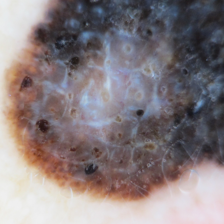

In [8]:
# plotting the first image in the training set
df_train_rs[24193]["image"]

In [9]:
# Create a TensorFlow dataset
tf_train = df_train_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=32,
            shuffle=True,
            drop_remainder=False
            )
tf_validation = df_validation_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=32,
            #shuffle=True,
            drop_remainder=False
            )
tf_test = df_test_rs.to_tf_dataset(
            columns='image',
            label_cols='label',
            batch_size=32,
            #shuffle=True,
            drop_remainder=False
            )

In [11]:
tf.data.Dataset.save(tf_train, 'Data_TF_saved/alldata224/train')
tf.data.Dataset.save(tf_validation, 'Data_TF_saved/alldata224/validation')
tf.data.Dataset.save(tf_test, 'Data_TF_saved/alldata224/test')



In [12]:
# Load the saved datasets
tf_train = tf.data.Dataset.load('Data_TF_saved/alldata224/train')
tf_validation = tf.data.Dataset.load('Data_TF_saved/alldata224/validation')
tf_test = tf.data.Dataset.load('Data_TF_saved/alldata224/test')

In [13]:
def preprocess_image(image, label):    
    image = tf.cast(image, tf.float32)/ 255.0
    return image, label

train_dataset_224 = tf_train.map(preprocess_image)
validation_dataset_224 = tf_validation.map(preprocess_image)
test_dataset_224 = tf_test.map(preprocess_image)



In [15]:
def process_dataset(dataset, target_size=(96, 96)):
    """
    Process a TensorFlow dataset into scaled images and labels suitable for ML models.
    
    Args:
        dataset: tf.data.Dataset containing image-label pairs
        target_size: tuple of (height, width) for image resizing
        
    Returns:
        processed_images: numpy array of flattened, scaled images
        labels: numpy array of labels
    """
    total_samples = len(list(dataset.as_numpy_iterator()))
    print(f"Total samples in dataset: {total_samples}")
    
    images_list = []
    labels_list = []
    
    # Process each image-label pair
    for image, label in dataset.unbatch():
        try:
            # Convert and resize image
            #image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, target_size)
            # Normalize to [0,1]
            image = image.numpy().astype('float32') #/ 255.0
            # Ensure correct shape
            if len(image.shape) == 2:
                image = np.expand_dims(image, axis=-1)
            # Flatten image
            images_list.append(image.reshape(-1))
            labels_list.append(label)
        except Exception as e:
            print(f"Error processing image with label {label}: {e}")
            
    
    # Stack and convert to numpy arrays
    processed_images = np.vstack(images_list)
    labels = np.array(labels_list)
    
    return processed_images, labels

# Usage example:
print("Processing train dataset...")
# draw a random sample of size 1000,100,100 from the training,val,test dataset for faster processing
train_dataset_32_numpy, train_labels_numpy = process_dataset(train_dataset_224)
print("Processing validation dataset...")
validation_dataset_32_numpy, validation_labels_numpy = process_dataset(validation_dataset_224)
print("Processing test dataset...")
test_dataset_32_numpy, test_labels_numpy = process_dataset(test_dataset_224)

Processing train dataset...
Total samples in dataset: 917
Processing validation dataset...
Total samples in dataset: 115
Processing test dataset...
Total samples in dataset: 115


In [16]:
# Print dimensions
print("\nDataset Dimensions:")
print("-" * 50)
print(f"Training Data:")
print(f"Images: {train_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {train_labels_numpy.shape}")
print(f"\nValidation Data:")
print(f"Images: {validation_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {validation_labels_numpy.shape}")
print(f"\nTest Data:")
print(f"Images: {test_dataset_32_numpy.shape} (samples, features)")
print(f"Labels: {test_labels_numpy.shape}")

# Print feature information
n_features = train_dataset_32_numpy.shape[1]
print(f"\nNumber of features per image: {n_features} (32x32x1 flattened)")


Dataset Dimensions:
--------------------------------------------------
Training Data:
Images: (29322, 150528) (samples, features)
Labels: (29322,)

Validation Data:
Images: (3660, 150528) (samples, features)
Labels: (3660,)

Test Data:
Images: (3674, 150528) (samples, features)
Labels: (3674,)

Number of features per image: 150528 (32x32x1 flattened)


In [17]:
# Save all data together
np.savez('Data_NP_saved/full_processed_datasets96x96x3.npz',
         train_images=train_dataset_32_numpy, train_labels=train_labels_numpy,
         validation_images=validation_dataset_32_numpy, validation_labels=validation_labels_numpy,
         test_images=test_dataset_32_numpy, test_labels=test_labels_numpy)





In [1]:
data = np.load('Data_NP_saved/full_processed_datasets96x96x3.npz')

# Access individual datasets
train_images = data['train_images']
train_labels = data['train_labels']
validation_images = data['validation_images']
validation_labels = data['validation_labels']
test_images = data['test_images']
test_labels = data['test_labels']

# Print shapes
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Images Shape:", validation_images.shape)
print("Validation Labels Shape:", validation_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (29322, 150528)
Train Labels Shape: (29322,)
Validation Images Shape: (3660, 150528)
Validation Labels Shape: (3660,)
Test Images Shape: (3674, 150528)
Test Labels Shape: (3674,)


In [2]:
#train dubplicates
unique_train, unique_train_idx, inverse_train_idx, train_counts = np.unique(train_images, axis=0, return_index=True, return_inverse=True, return_counts=True)

duplicates_train = np.where(train_counts > 1)[0]
print(f"Number of duplicate images in training set: {len(train_images) - len(unique_train)}")

# Visualize duplicates
"""for idx in duplicates_train:
    duplicate_ids = np.where(inverse_train_idx == idx)[0]
    print(f"Duplicates for unique image index {idx}: {duplicate_ids}")
    # Example: visualize
    fig, axs = plt.subplots(1, len(duplicate_ids), figsize=(10, 2))
    if len(duplicate_ids) == 1:
        axs = [axs]
    for i, dup_id in enumerate(duplicate_ids):
        axs[i].imshow(train_images[dup_id].reshape(32, 32, 3))
        axs[i].set_title(f"Idx: {dup_id}")
        axs[i].axis('off')
    plt.show()"""


train_images = train_images[unique_train_idx]
train_labels = train_labels[unique_train_idx]

#val dubplicates
unique_val, unique_val_idx = np.unique(validation_images, axis=0, return_index=True)
print(f"Number of duplicate images in validation set: {len(validation_images) - len(unique_val)}")
validation_images = validation_images[unique_val_idx]
validation_labels = validation_labels[unique_val_idx]

#test dubplicates
unique_test, unique_test_idx = np.unique(test_images, axis=0, return_index=True)
print(f"Number of duplicate images in test set: {len(test_images) - len(unique_test)}")
test_images = test_images[unique_test_idx]
test_labels = test_labels[unique_test_idx]

# shapes
print("After removing duplicates:")
print(f"Train set: {train_images.shape}")
print(f"Validation set: {validation_images.shape}")
print(f"Test set: {test_images.shape}")


Number of duplicate images in training set: 654
Number of duplicate images in validation set: 9
Number of duplicate images in test set: 11
After removing duplicates:
Train set: (28668, 150528)
Validation set: (3651, 150528)
Test set: (3663, 150528)


In [3]:
np.savez('Data_NP_saved/for_cnn_96x96x3.npz',
         train_images=train_images, train_labels=train_labels,
         validation_images=validation_images, validation_labels=validation_labels,
         test_images=test_images, test_labels=test_labels)

PCA

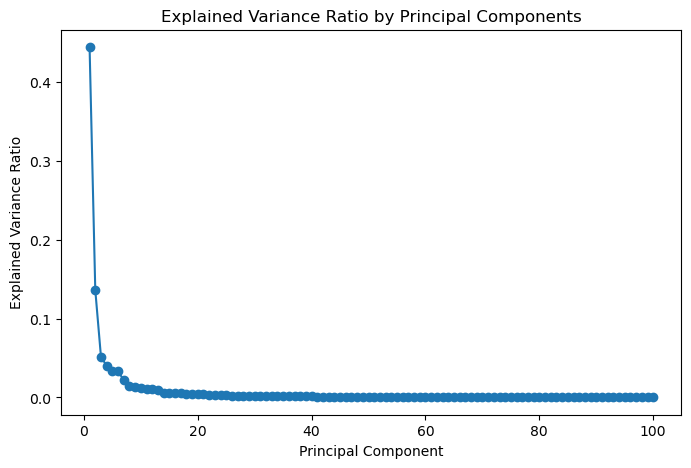

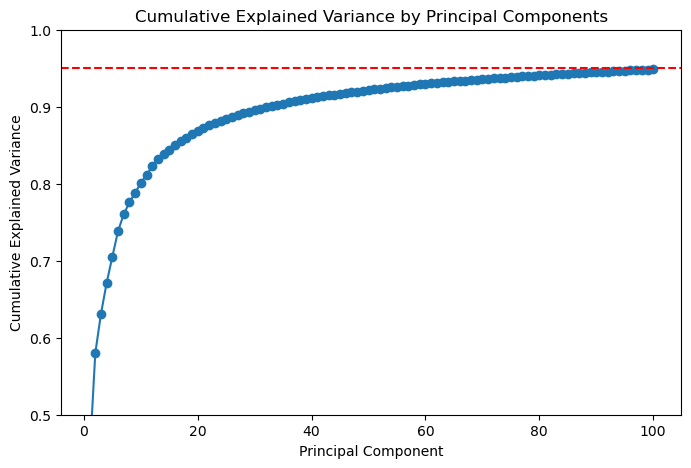

In [3]:

pca = PCA(n_components=100, random_state=42)
pca.fit(train_images)

train_images_pca = pca.transform(train_images)
validation_images_pca = pca.transform(validation_images)
test_images_pca = pca.transform(test_images)


plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance Ratio by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()


cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.ylim(0.5, 1)
plt.axhline(y=0.95, color='r', linestyle='--')  # For 95% variance
plt.show()

train_images = train_images_pca
validation_images = validation_images_pca
test_images = test_images_pca

GradientBoosting classifier optimal run

In [11]:
optimal_params = {
    'learning_rate': 0.018,
    'max_iter': 750,
    'max_depth': 11,
    'l2_regularization': 0.324
}

# Start a W&B run
wandb.init(project="shallow-learners-TEST6", name="GB-32x32x3_TEST", config=optimal_params)



# Initialize the classifier with optimal parameters
classifier = HistGradientBoostingClassifier(
    learning_rate=optimal_params['learning_rate'],
    max_iter=optimal_params['max_iter'],
    max_depth=optimal_params['max_depth'],
    l2_regularization=optimal_params['l2_regularization']
)

# Train the model
print("Training HistGradient Boosting classifier with optimal parameters...")
classifier.fit(train_images, train_labels)

# Evaluate on the validation set
val_predictions = classifier.predict(validation_images)
val_accuracy = accuracy_score(validation_labels, val_predictions)

# Evaluate on the training set
train_predictions = classifier.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on the test set
test_predictions = classifier.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)

# Class-wise accuracy for test set
classification_details = classification_report(test_labels, test_predictions, output_dict=True)
class_accuracies = {}
for label, metrics in classification_details.items():
    if label.isdigit():
        class_accuracies[f'class_{label}_accuracy'] = metrics['recall']

# Log metrics to W&B
wandb.log({
    "val_accuracy": val_accuracy,
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy,
    **class_accuracies
})


# Finish the W&B run
wandb.finish()


Training HistGradient Boosting classifier with optimal parameters...


c:\Users\Fuglsang\miniconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fuglsang\miniconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fuglsang\miniconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.6814571350314982
Train Accuracy: 0.9196986081557191
Test Accuracy: 0.6784056784056784
Class-wise Accuracy:
class_0_accuracy: 0.08
class_1_accuracy: 0.59
class_2_accuracy: 0.18
class_3_accuracy: 0.67
class_4_accuracy: 0.63
class_5_accuracy: 0.00
class_6_accuracy: 0.80
class_7_accuracy: 0.83
class_8_accuracy: 0.59
class_9_accuracy: 0.89
class_10_accuracy: 0.40
class_11_accuracy: 0.92
class_12_accuracy: 0.00
class_13_accuracy: 0.08


class_0_accuracy,▁
class_10_accuracy,▁
class_11_accuracy,▁
class_12_accuracy,▁
class_13_accuracy,▁
class_1_accuracy,▁
class_2_accuracy,▁
class_3_accuracy,▁
class_4_accuracy,▁
class_5_accuracy,▁
class_6_accuracy,▁


SCM classifier optimal run

In [12]:
optimal_params = {
    'C': 15,
    'kernel': 'rbf',
    'gamma': 'scale',
}

# Start a W&B run
wandb.init(project="shallow-learners-TEST6", name="SVM-32x32x3-test", config=optimal_params)

# Initialize the classifier with optimal parameters
classifier = SVC(
    C=optimal_params['C'],
    kernel=optimal_params['kernel'],
    gamma=optimal_params['gamma']
)

# Train the model
print("Training SVM  classifier with optimal parameters...")
classifier.fit(train_images, train_labels)

# Evaluate on the validation set
val_predictions = classifier.predict(validation_images)
val_accuracy = accuracy_score(validation_labels, val_predictions)

# Evaluate on the training set
train_predictions = classifier.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on the test set
test_predictions = classifier.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)

# Class-wise accuracy for test set
classification_details = classification_report(test_labels, test_predictions, output_dict=True)
class_accuracies = {}
for label, metrics in classification_details.items():
    if label.isdigit():
        class_accuracies[f'class_{label}_accuracy'] = metrics['recall']

# Log metrics to W&B
wandb.log({
    "val_accuracy": val_accuracy,
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy,
    **class_accuracies
})

# Finish the W&B run
wandb.finish()


Training SVM  classifier with optimal parameters...
Validation Accuracy: 0.6822788277184333
Train Accuracy: 0.8324205532493808
Test Accuracy: 0.6732186732186732
Class-wise Accuracy:
class_0_accuracy: 0.18
class_1_accuracy: 0.67
class_2_accuracy: 0.24
class_3_accuracy: 0.59
class_4_accuracy: 0.71
class_5_accuracy: 0.00
class_6_accuracy: 0.76
class_7_accuracy: 0.81
class_8_accuracy: 0.68
class_9_accuracy: 0.89
class_10_accuracy: 0.31
class_11_accuracy: 0.86
class_12_accuracy: 0.03
class_13_accuracy: 0.12


class_0_accuracy,▁
class_10_accuracy,▁
class_11_accuracy,▁
class_12_accuracy,▁
class_13_accuracy,▁
class_1_accuracy,▁
class_2_accuracy,▁
class_3_accuracy,▁
class_4_accuracy,▁
class_5_accuracy,▁
class_6_accuracy,▁


RF classifier optimal run

In [13]:
import wandb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Optimal hyperparameters from the sweep
optimal_params = {
    'n_estimators': 700,
    'min_samples_split': 2, 
    'min_samples_leaf': 1,  
    'max_depth': 25,
    'max_features': 'sqrt', 
}

# Start a W&B run
wandb.init(project="shallow-learners-TEST6", name="RF-32x32x3-TEST", config=optimal_params)

# Initialize the classifier with optimal parameters
classifier = RandomForestClassifier(
    n_estimators=optimal_params['n_estimators'],
    min_samples_split=optimal_params['min_samples_split'],
    min_samples_leaf=optimal_params['min_samples_leaf'],
    max_depth=optimal_params['max_depth'],
    max_features=optimal_params['max_features'],
    n_jobs=-1,
    class_weight='balanced_subsample'
)

# Train the model
print("Training RF classifier with optimal parameters...")
classifier.fit(train_images, train_labels)

# Evaluate on the validation set
val_predictions = classifier.predict(validation_images)
val_accuracy = accuracy_score(validation_labels, val_predictions)

# Evaluate on the training set
train_predictions = classifier.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on the test set
test_predictions = classifier.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)

# Class-wise accuracy for test set
classification_details = classification_report(test_labels, test_predictions, output_dict=True)
class_accuracies = {}
for label, metrics in classification_details.items():
    if label.isdigit():  # Check if the label is a class label (numeric)
        class_accuracies[f'class_{label}_accuracy'] = metrics['recall']

# Log metrics to W&B
wandb.log({
    "val_accuracy": val_accuracy,
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy,
    **class_accuracies  # Log class-wise accuracies
})

# Log additional details (optional)
print("Validation Accuracy:", val_accuracy)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Class-wise Accuracy:")
for class_name, acc in class_accuracies.items():
    print(f"{class_name}: {acc:.2f}")

# Finish the W&B run
wandb.finish()


Training RF classifier with optimal parameters...


c:\Users\Fuglsang\miniconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fuglsang\miniconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fuglsang\miniconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.6652971788551082
Train Accuracy: 0.9999651166846897
Test Accuracy: 0.6576576576576577
Class-wise Accuracy:
class_0_accuracy: 0.09
class_1_accuracy: 0.49
class_2_accuracy: 0.10
class_3_accuracy: 0.64
class_4_accuracy: 0.60
class_5_accuracy: 0.00
class_6_accuracy: 0.79
class_7_accuracy: 0.79
class_8_accuracy: 0.62
class_9_accuracy: 0.96
class_10_accuracy: 0.15
class_11_accuracy: 0.94
class_12_accuracy: 0.00
class_13_accuracy: 0.04


class_0_accuracy,▁
class_10_accuracy,▁
class_11_accuracy,▁
class_12_accuracy,▁
class_13_accuracy,▁
class_1_accuracy,▁
class_2_accuracy,▁
class_3_accuracy,▁
class_4_accuracy,▁
class_5_accuracy,▁
class_6_accuracy,▁


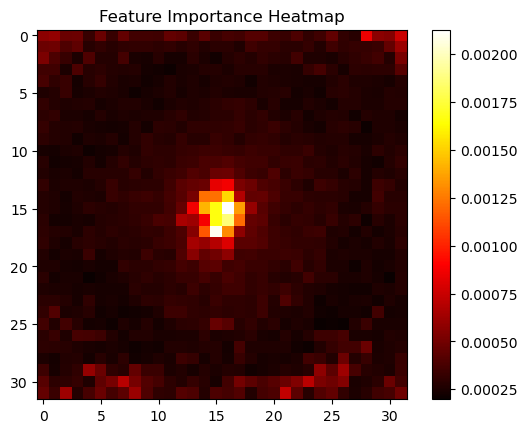

In [9]:
feature_importances = classifier.feature_importances_

# Visualize feature importance as a heatmap
importance_image = feature_importances.reshape(32, 32, 3).mean(axis=2)  # Average across RGB channels
plt.imshow(importance_image, cmap='hot')
plt.colorbar()
plt.title("Feature Importance Heatmap")
plt.show()

In [14]:


# Optimal hyperparameters for GB
optimal_params_GB = {
    'learning_rate': 0.026784,
    'max_iter': 1162,
    'max_depth': 11,
    'l2_regularization': 0.69705
}


# Optimal hyperparameters for SVC
optimal_params_SVC = {
    'C': 1,        
    'kernel': 'rbf',
    'gamma': 'scale',
    'class_weight': 'balanced'
}



# Optimal hyperparameters for RF
optimal_params_RF = {
    'n_estimators': 1850,
    'min_samples_split': 9, 
    'min_samples_leaf': 1,  
    'max_depth': 80,
    'max_features': 'sqrt', 
    'class_weight': 'balanced_subsample',
}

# Start a W&B run
wandb.init(project="shallow-learners-stacking", name="stacking-32x32x3", config={
    "GB_params": optimal_params_GB,
    "SVC_params": optimal_params_SVC,
    "RF_params": optimal_params_RF
})


gb_clf = HistGradientBoostingClassifier(
    learning_rate=optimal_params_GB['learning_rate'],
    max_iter=optimal_params_GB['max_iter'],
    max_depth=optimal_params_GB['max_depth'],
    l2_regularization=optimal_params_GB['l2_regularization']
)


svc_clf = SVC(
    C=optimal_params_SVC['C'],
    kernel=optimal_params_SVC['kernel'],
    gamma=optimal_params_SVC['gamma'],
    probability=True,
    class_weight=optimal_params_SVC['class_weight']
)



rf_clf = RandomForestClassifier(
    n_estimators=optimal_params_RF['n_estimators'],
    min_samples_split=optimal_params_RF['min_samples_split'],
    min_samples_leaf=optimal_params_RF['min_samples_leaf'],
    max_depth=optimal_params_RF['max_depth'],
    max_features=optimal_params_RF['max_features'],
    class_weight=optimal_params_RF['class_weight']
)




# Initialize the voting classifier 
classifier = VotingClassifier(
    estimators=[
        ('gradient_boosting', gb_clf),
        ('support_vector', svc_clf),
        ('random_forest', rf_clf)
    ],
    voting='soft',
    n_jobs=-1
)


# Combine training and validation datasets
train_images_combined = np.concatenate((train_images, validation_images), axis=0)
train_labels_combined = np.concatenate((train_labels, validation_labels), axis=0)

# Train the model
print("Training voting classifier with optimal parameters on combined training data...")
classifier.fit(train_images_combined, train_labels_combined)

# Evaluate on the test set
test_predictions = classifier.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)

# Class-wise accuracy for the test set
classification_details = classification_report(test_labels, test_predictions, output_dict=True)
class_accuracies = {}
for label, metrics in classification_details.items():
    if label.isdigit():  # Check if the label is a class label (numeric)
        class_accuracies[f'class_{label}_accuracy'] = metrics['recall']

# Log metrics to W&B
wandb.log({
    "test_accuracy": test_accuracy,
    **class_accuracies  # Log class-wise accuracies
})

# Log additional details (optional)
print("Test Accuracy:", test_accuracy)
print("Class-wise Accuracy:")
for class_name, acc in class_accuracies.items():
    print(f"{class_name}: {acc:.2f}")

# Finish the W&B run
wandb.finish()



Training voting classifier with optimal parameters on combined training data...


KeyboardInterrupt: 